In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#maybe usefull
from sklearn.feature_selection import SelectKBest, chi2

In [2]:
#liest die Datensätze ein
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
#change the strings into values and clear up NaN
def transf_strings_in_values(x):
    #Lines with strings
    lws = x.dtypes[x.dtypes == "object"].index
    los = x.dtypes[x.dtypes != "object"].index
    
    for a in lws:
        x[a] = x[a].fillna("Unknown")
        strings = np.unique(train[a])
        for b in strings:
            table = train[a] == b
            train[a][table] = np.searchsorted(strings,b)
    for a in los:
        x[a] = x[a].fillna(np.mean(x[a]))
transf_strings_in_values(train)

/home/maximilian/.local/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
Train = {'feature_names': train.columns[1:], 'data': train.values[:,1:-1].astype(np.float32), 'target': train.values[:,-1].astype(np.float32)}

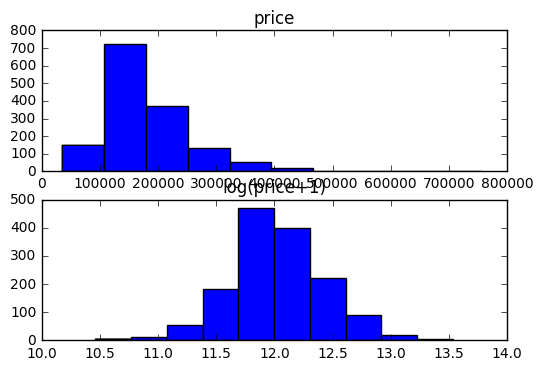

In [5]:
#Some plots for better understanding

f, ax = plt.subplots(2, 1)
ax[0].hist(Train['target'])
ax[0].set_title('price')
ax[1].hist(np.log1p(Train['target']))
ax[1].set_title('log(price+1)')
plt.show()

In [7]:
#feature selection with chi 2
#don't operate this because everything crashes 

Train['data'] = np.log1p(Train['data'])
Train['target'] = np.log1p(Train['target'])

newFe = SelectKBest(chi2, k=3).fit(Train['data'],Train['target'])
Fit = newFe.fit_transform(Train['data'],Train['target'])
score = sorted(range(len(newFe.scores_)), key=lambda x: newFe.scores_[x])[-3:]
for a in score:
    print(Train['feature_names'][a])

ValueError: Unknown label type: (array([ 12.24769878,  12.10901642,  12.3171711 , ...,  12.49313354,
        11.86446953,  11.90159035], dtype=float32),)

In [12]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier(n_estimators=150, max_depth=10)
clf = clf.fit(Train['data'], Train['target'])
importants = clf.feature_importances_  

model = SelectFromModel(clf, threshold=0.02, prefit=True)
feature = model.transform(Train['data']).shape[1]
while feature > 3:
    model.threshold +=0.0001
    X_trans = model.transform(Train['data'])
    feature = X_trans.shape[1]

indices = np.argsort(importants)[len(importants)-3:len(importants)]
print("Feature ranking:")
for f in indices:
    print("%d. feature %s (%f)" % (f + 1, Train['feature_names'][f], importants[f]))

Feature ranking:
20. feature YearRemodAdd (0.022590)
76. feature MoSold (0.022902)
46. feature GrLivArea (0.023151)


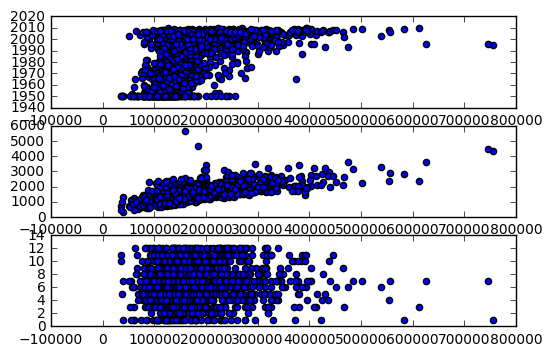

In [13]:
f, ax = plt.subplots(3, 1)
ax[0].scatter(Train['target'],X_trans[:,0])
ax[1].scatter(Train['target'],X_trans[:,1])
ax[2].scatter(Train['target'],X_trans[:,2])
plt.show()